## Choose Our Model
- 训练误差：模型在训练数据上的误差
- 泛化误差：模型在新数据上的误差 （我们更关注这个误差）
- validation dataset:可以多次使用，验证数据集没有参加训练，可以反映超参数的选择好坏。
比如我们改超参数前后，在验证集上进行测试。注意：验证数据集不能参加训练。
验证数据集的精度可能也是虚高的，因为我们的超参数就在验证数据集上调出来的。
- testing dataset:只能用一次，不能用来调超参数。一定不能learning the model to fit the test model。
- 模型复杂度对欠拟合和过拟合的影响：
![avatar](./imgs/11-3.png)

## K-folder cross validation
没有足够多的数据时使用

简单的验证的缺陷：
- 在不同的划分方法下，test MSE的变动是很大的，而且对应的最优degree也不一样。所以如果我们的训练集和测试集的划分方法不够好，很有可能无法选择到最好的模型与参数。
- 该方法只用了部分数据进行模型的训练.

算法：
- 将数据分割成K块
- for i = 1,..,k 
- 使用第i块作为验证数据集，其余作为训练数据集
- 报告K个验证集误差的平均,作为该次超参数的评估的误差结果

交叉验证的缺点：
- 耗时长

常用：k = 5或者10

极端情况：n个数据使用n折交叉验证 （Leave-one-out cross-validation）

## Overfitting and Underfitting
###### 模型容量：
- 拟合各种函数的能力
- 低容量模型难以拟合训练数据： 比如线性模型难以拟复杂的训练数据
- 高容量的模型可以记住所有的数据： 比如很复杂的模型可以拟合完全所有的训练数据
- 为了下降泛化误差，需要去包容一定程度的过拟合。（**泛化误差本身的曲 VS 泛化误差和训练误差的间隔**）

###### 模型容量的估计：
- 难以在不同的种类算法之间进行比较：树模型和神经网络
- 给定一个模型重要，将有俩主要元素：
1. 参数的个数
2. 参数值的选择范围

##### 估计模型容量的指标： VC维
- 对于一个分类模型，VC维等于一个最大的数据集的大小。不管如何给定标号
，都存在一个模型来对它进行完美分类。
- 举个例子，2维输入的感知机(即线性分类器)，VC=3，即能够分类任何3个点，而不是4个
- 支持N维度输出的感知机的VC维是N+1
- 但是深度学习很少用，因为深度学习模型的VC维计算困难。

##### 图示
数据复杂时候应该使用容量高的模型
![avatar](./imgs/11-1.png)
![avatar](./imgs/11-2.png)

In [40]:
import math
import numpy as np

import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision import transforms
from IPython import display # for animator
import matplotlib.pyplot as plt

### 广播机制
- numpy中的数组相乘，默认为对应元素相乘。矩阵乘法用的是`np.matmul`.
- 在广播机制中，两个数组的"尾数"的维度相同或者有一方为1.
- 注意理解，这里的尾数维度并不要求是同一维度。比如4 * 3 和 3，他们的尾数就相同
- 比较难的情况是：4 * 1 和  3，这时候需要用到两次广播机制。

- `a[:,np.newaxis]+b`的做法：
(1) 先比较最低维（即尾数维度）:在我们的例子中，`a[:,np.newaxis]`的尾数维度为1，b的尾数维度为3，所以我们需要把a按行去复制，复制成（4，3）的格式。
(2)如果两个矩阵的dimension还不相等，再接着比较倒数第二维,b的倒数第二维没有了，为1，a的倒数第二维为4，所以我们需要把b去复制，复制成（4，3）的格式。
具体过程如下：
![avatar](./imgs/11-4.png)

In [41]:
a = np.array([0.0,10.0,20.0,30.0])
b = np.array([1.0,2.0,3.0])

a.shape, b.shape,a[:,np.newaxis].shape, a[:,np.newaxis]+b

((4,),
 (3,),
 (4, 1),
 array([[ 1.,  2.,  3.],
        [11., 12., 13.],
        [21., 22., 23.],
        [31., 32., 33.]]))

#### 数据生成
![avatar](./imgs/11-5.png)

In [42]:
# build a synthetic dataset
max_degree = 20 # more than 4, because we will try overfitting later
n_train, n_test = 100, 100 #这里的test其实是验证集
true_w = np.zeros(max_degree) #打乱顺序
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size = (n_train+n_test,1))
np.random.shuffle(features)
# np.power:If x1.shape != x2.shape, they must be broadcastable to a common shape
# (200,1),(1,20) ——> (200,20),(200,20)
poly_features = np.power(features,np.arange(max_degree).reshape(1,-1))

for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i + 1) #`gamma(n)` = (n-1)!

labels = np.dot(poly_features, true_w)
labels += np.random.normal(size = labels.shape)

In [50]:
class Accumulator:
    # sum up on "n" variables
    def __init__(self, n):
        self.data = [0.0] * n  # [0.0]*2 -> [0.0, 0.0]
        
    def add(self, *args): #"self.data" and "args" should have the same dim
        self.data = [a + float(b)for a, b in zip(self.data,args)] # zip: -> tuples (corresponding)
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self,idx):
        return self.data[idx]

def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1: # 2 dimension
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) ==y
    return float(cmp.type(y.dtype).sum())
def evaluate_loss(net,data_iter,loss):
    metric = Accumulator(2)
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]           

In [44]:
# NumPy ndarray to tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0340],
         [ 1.4140]]),
 tensor([[ 1.0000e+00, -3.3964e-02,  5.7677e-04, -6.5297e-06,  5.5443e-08,
          -3.7661e-10,  2.1318e-12, -1.0344e-14,  4.3913e-17, -1.6572e-19,
           5.6284e-22, -1.7378e-24,  4.9186e-27, -1.2850e-29,  3.1174e-32,
          -7.0586e-35,  1.4983e-37, -2.9935e-40,  5.6472e-43, -1.4013e-45],
         [ 1.0000e+00,  1.4140e+00,  9.9975e-01,  4.7123e-01,  1.6658e-01,
           4.7111e-02,  1.1103e-02,  2.2429e-03,  3.9644e-04,  6.2286e-05,
           8.8075e-06,  1.1322e-06,  1.3341e-07,  1.4512e-08,  1.4657e-09,
           1.3817e-10,  1.2211e-11,  1.0157e-12,  7.9793e-14,  5.9385e-15]]),
 tensor([3.5546, 5.6730]))

In [45]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [46]:
# Defined in file: ./chapter_preliminaries/calculus.md
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')
    
# Defined in file: ./chapter_preliminaries/calculus.md
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [47]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

In [48]:
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric = Accumulator(3) # 训练损失总和、训练准确度总和、样本数
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat,y),
                y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0]) # X.shape[0] is batchsize
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2] #loss/all, correct classified/all 
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss,train_acc = train_metrics

weight: [[ 4.943358   1.3368512 -3.373848   5.505994 ]]


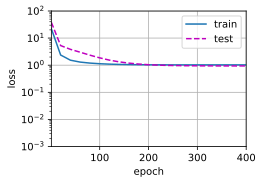

In [51]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])
# 注意：这里训练和测试之间的gap很小，即没有多少overfitting

weight: [[3.2879646 4.055108 ]]


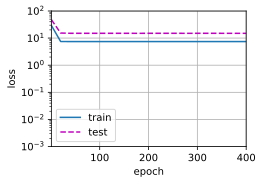

In [53]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])
# 注意这里损失非常高，即underfit

weight: [[ 4.88428     1.410823   -3.1201212   5.1022673  -0.6963537   1.4190295
  -0.21810988 -0.03164281 -0.0910608  -0.04140541 -0.18300693 -0.05036066
  -0.07519221 -0.18106823 -0.12795046 -0.17321216  0.13701984 -0.14425938
  -0.14308721 -0.17857946]]


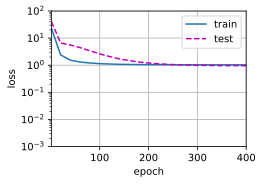

In [54]:
train(poly_features[:n_train, :20], poly_features[n_train:, :20],
      labels[:n_train], labels[n_train:])
# 注意：这里训练和测试之间的gap很大，即overfitting

###### 